In [1]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
torch.manual_seed(42)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Preparing the Training Data

```
The MNIST dataset consists of 28 × 28 pixel grayscale images of handwritten digits from 0 to 9. To use them with PyTorch, you’ll need to perform some conversions. For that, you define transform, a function to be used when loading the data
```

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [4]:
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

In [5]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

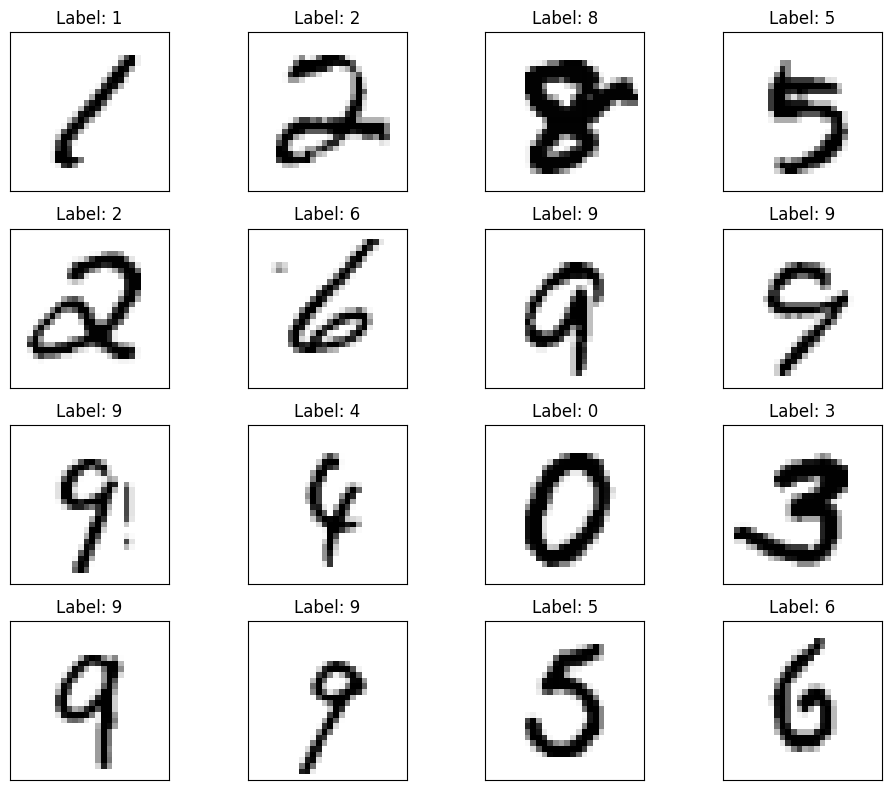

In [6]:
real_samples, mnist_labels = next(iter(train_loader))
plt.figure(figsize=(10,8))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.title("Label: {}".format(mnist_labels[i]))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

# Implementing the Discriminator and the Generator

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output
    
discriminator = Discriminator().to(device=device)

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)

In [9]:
lr = 0.0001
num_epochs = 100
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [10]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.5394870042800903
Epoch: 0 Loss G.: 0.5199116468429565
Epoch: 1 Loss D.: 0.008022863417863846
Epoch: 1 Loss G.: 6.239060878753662
Epoch: 2 Loss D.: 0.03474148362874985
Epoch: 2 Loss G.: 10.487638473510742
Epoch: 3 Loss D.: 0.010527508333325386
Epoch: 3 Loss G.: 5.112671375274658
Epoch: 4 Loss D.: 0.07141007483005524
Epoch: 4 Loss G.: 6.29166316986084
Epoch: 5 Loss D.: 0.004254281520843506
Epoch: 5 Loss G.: 6.605588912963867
Epoch: 6 Loss D.: 0.0002453443012200296
Epoch: 6 Loss G.: 9.5966796875
Epoch: 7 Loss D.: 1.2033594008801463e-18
Epoch: 7 Loss G.: 56.302494049072266
Epoch: 8 Loss D.: 5.900211454681123e-20
Epoch: 8 Loss G.: 52.935176849365234
Epoch: 9 Loss D.: 0.011299075558781624
Epoch: 9 Loss G.: 10.078493118286133
Epoch: 10 Loss D.: 1.664896626607515e-05
Epoch: 10 Loss G.: 14.64488410949707
Epoch: 11 Loss D.: 0.003960626199841499
Epoch: 11 Loss G.: 6.400813579559326
Epoch: 12 Loss D.: 6.146741071688666e-08
Epoch: 12 Loss G.: 45.84676742553711
Epoch: 13 Loss D.:

In [11]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

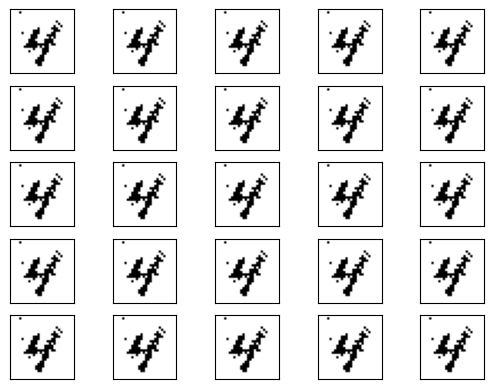

In [12]:
generated_samples = generated_samples.cpu().detach()
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])
plt.show()

# Reference
#### https://realpython.com/generative-adversarial-networks/